In [2]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Instructions for technical review

This notebook has been developed to allow SARAO staff to conduct a review of the technical feasibility of proposals received in the December 2018 MeerKAT call for Open Time Proposals.

Reviewers are asked to assess the following:
* Sensitivity calculation. Confirm that the calculation is correct. It does not have to be precise, since we know that there are many factors that will influence the noise levels in an image, but it should be in the same 'ballpark'. If there are inconsistencies, please use the 'issues identified' column on the review spreadsheet to indicate the issue.  If the observation can be done in less time, please also note this.
    
* Can it be done - For example, are the observing modes and scan types supported. Please also identify if the proposal requires full polarisation data. 
    
* Scheduling difficulties - for example an unreasonable set of short observations
    
Use the observation rating dropdown list to rate the feasibility of the observation:

    A - Observation can be done as requested
    B - Observation plan needs to be adjusted
    C - This cannot be done in 16 hours or under the current conditions of the call. eg asking for a mode that is not supported, or doubts about array performance.

(SDP Specific) - How do they plan to retrieve and process the data.				
					
Use the rating drop down to estimate how much tech support the observation requires:

    A - Little to no additional technical support needed				
	B - Some technical support needed, but no major developments				
	C - Not currently feasible from a technical perspective				
					


# Continuum sensitivity

Working out the expected rms in a continuum image is not a straightforward exercise, due to the complex interaction between the robustness factor, uv-track density, and confusion noise (not to mention, different ways of estimating confusion noise). 

Firstly, here's a thermal noise simulation (B. Hugo). The curves show the **thermal noise rms** as a function of robustness, for a range of integration times. The bottom curve is for 2 hours on-source. The grey area on the bottom shows the estimated **confusion noise** as a function of robustness (somewhat overestimated, given the second plot). An RFI mask has been applied in the sim, so the bandwidth used is realistic.

![2h sensitivity](https://www.dropbox.com/s/xu7ov4i4letjmun/sensitivity-sim-2h.png?raw=1)

On the other end, we have a plot made using actual COSMOS data (I. Heywood). This shows rms image noise, in uJy, **thermal + confusion** as a function of robustness after 19 hours on-source:

![19h sensitivity](https://www.dropbox.com/s/9nm36vom1ig7q83/sensitivity-cosmos-19h.png?raw=1)

Suggested procedure to use the above two curves as a bracket and interpolate in between using the tool below

### Sensitivity calculator

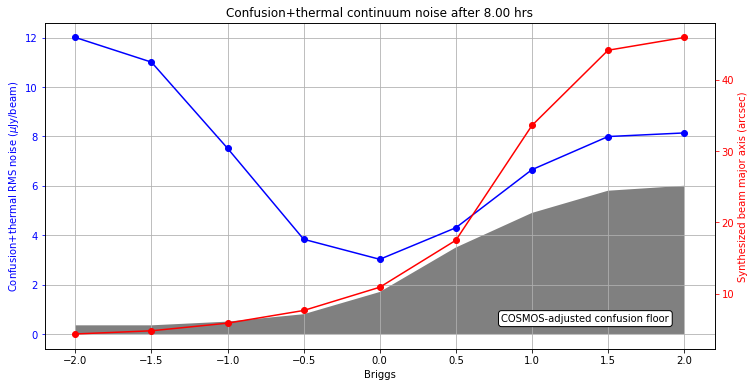

Best estimate for RMS in image: 3.02 muJy


In [16]:
NUM_HRS = 8.0    # modify this with your on-source time 

# dont mod below this line
# ---------------------------
briggs = np.array([-2, -1.5, -1.0, -0.5, 0, 0.5, 1, 1.5, 2.0])
synth_beam = np.array([4.35626, 4.80342, 5.87383, 7.65118, 10.911, 17.4973, 33.5949, 44.1468, 45.9398])
rms2hrs = np.array([24, 22, 15, 7.5, 5, 5, 9, 11, 11])
mightee_s3_confusion_limit = np.array([0.35,0.35,0.5,0.8,1.7,3.8,8.0,14,15])
ian_confusion_limit = np.array([8.5, 4.5, 2.9, 2.5, 3, 3.5, 4.9, 5.8, 6])
confusion_limit = np.min(np.vstack([mightee_s3_confusion_limit,
                                    ian_confusion_limit]), axis=0)

rms_scaling_factor = np.sqrt(2.0) / np.sqrt(NUM_HRS)
#rms_sensitivity = np.max(np.vstack([rms2hrs * rms_scaling_factor, 
#                                    confusion_limit]),
#                         axis=0)
rms_sensitivity = np.sqrt((np.vstack([rms2hrs * rms_scaling_factor, 
                                    confusion_limit])**2).sum(axis=0))

from matplotlib import pyplot as plt
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(briggs, rms_sensitivity, 'bo-', label="Expected worst case after {0:.2f} hrs".format(NUM_HRS))
ax1.set_xlabel("Briggs")
ax1.set_title("Confusion+thermal continuum noise after {0:.2f} hrs".format(NUM_HRS))
ax1.set_ylabel("Confusion+thermal RMS noise ($\mu$Jy/beam)", color='b')
ax1.tick_params('y', colors='b')
ax1.grid(True)
ax1.fill_between(briggs, np.zeros_like(mightee_s3_confusion_limit), confusion_limit, facecolor="gray")
ax1.text(0.8, 0.5, "COSMOS-adjusted confusion floor",
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
ax2 = ax1.twinx()
plt2 = ax2.plot(briggs, synth_beam, 'ro-', label="Synthesized beam extent".format(NUM_HRS))
ax2.set_ylabel("Synthesized beam major axis (arcsec)", color='r')
ax2.tick_params('y', colors='r')
plt.show()

print "Best estimate for RMS in image: {0:.2f} muJy".format(np.min(rms_sensitivity))

# Spectral line sensitivity

First, Tsys as a function of frequency. This is based on a [spreadsheet generated by Justin](https://docs.google.com/spreadsheets/d/1otXwwLQt9Yz9QyTMhCTpsiAavDzVfmh8h4SNwsKL-ck/edit#gid=330521686).

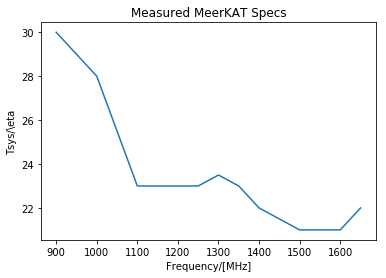

In [3]:
# from http://public.ska.ac.za/meerkat/meerkat-schedule
specs = array([[900,578,30.0,4.77],
        [950,559,29.0,4.94],
        [1000,540,28.0,5.11],
        [1050,492,25.5,5.61],
        [1100,443,23.0,6.22],
        [1150,443,23.0,6.22],
        [1200,443,23.0,6.22],
        [1250,443,23.0,6.22],
        [1300,453,23.5,6.09],
        [1350,443,23.0,6.22],
        [1400,424,22.0,6.51],
        [1450,415,21.5,6.66],
        [1500,405,21.0,6.82],
        [1550,405,21.0,6.82],
        [1600,405,21.0,6.82],
        [1650,424,22.0,6.51]])
plot(specs[:,0],specs[:,2])
a = title('Measured MeerKAT Specs')
a = ylabel('Tsys/\eta')
a = xlabel('Frequency/[MHz]')

In [4]:
k = 1.38e-23
J = 1e26                                   # Jy to Watts conversion factor
f = specs[:,0]*1e6                         # frequency axis above, Hz
lam = 3e8/f                                # corresponding wavelengths
c = 2.99792456e5
print '4k mode channel width : %f km/s '%(209000*c/1421e6 )

4k mode channel width : 44.093331 km/s 


For reference, the calculations that went into this are:

$\frac{\Delta\nu}{\Delta velo } = \frac{\nu_{rest}}{c}  $

$\nu_{rest} = 1421.0$ MHz

c = 2.99792456e+05 $km.s^{-1}$

$ \Delta velo = 16 km.s^{-1}$

$\Delta\nu = 75807.4180101$ Hz

A 5$\sigma$ sensitivity in the intensity of an image is found using $5\sigma_{S} = 5 \frac{2 k T_{sys}}{A_{eff} [2N(N-1)\Delta \nu_{\rm RF}\tau]^{1/2}}$ 


equations from http://www.atnf.csiro.au/people/Tobias.Westmeier/tools_hihelpers.php

$ T_{\rm B} = \frac{606 \, S}{\vartheta^{2}}$

$\vartheta $ is in arcseconds  , and the flux is in mJy

$N_{\rm H\,I} = 1.823 \times 10^{18} \! \int \! T_{\rm B} \, \mathrm{d}v $          
          
$ \mathrm{d}v $ is in $km.s^{-1}$

In [5]:
# Parameters to adjust for the observation 
F_tap = 1.6          # The Robust/tapering factor.
theta = 60.          # The beam size in arcseconds  
N_hi = 1e19          #  HI column Density cm^{-2}
SN = 3               # Signal to Noise for detection
hours = 16            # Time in Hours
N = 58               # Number of Antennas
velocity_width = 44. # in km.s^1 
obs_freq =1.421e9    # Observation frequency in Hz

Use the cell below to compute the flux of a spectral feature:

In [6]:
print "Flux of a column density:"
delta_v = velocity_width 
col_flux = N_hi*theta**2/(1.823e18*606.*delta_v)
string1 = "N_hi = {0:2.4g} at {1} arc-seconds  with a velocity width of {2:2.4g} km/s, has a flux of {3:2.4g} mJy. "
string2 = "To detect this at a {1:.0f}-sigma level (taper factor of {2:2.2g}),\nwe would need an image with a natural rms of {3:2.4g} mJy"
print string1.format(N_hi,theta,velocity_width,col_flux)
print string2.format(N_hi,SN,F_tap,col_flux/(F_tap*SN))

Flux of a column density:
N_hi = 1e+19 at 60.0 arc-seconds  with a velocity width of 44 km/s, has a flux of 0.7406 mJy. 
To detect this at a 3-sigma level (taper factor of 1.6),
we would need an image with a natural rms of 0.1543 mJy


Use the cell below to compute the image rms (single-channel), and resulting detecion level:

In [7]:
sigma = SN 
D = 13.5             # Meters
h1 = 1420405751.7667 # Hz
NPol = 2
A = np.pi * (D/2)**2
Tsys_eta = specs[:,2]
bw = h1/c*velocity_width    
tau = 3600 * hours
Tsys_per_eta = Tsys_eta[np.argmin(np.abs(f - obs_freq))]
print ("T_sys/eta at %3.0f MHz is %2.1fK"%(obs_freq/1e6,Tsys_per_eta) )
print("Flux/rms calculated from the observing time: ")
noise = 2 * k * Tsys_per_eta / (A * np.sqrt(N * (N-1) * bw * tau)) * J / np.sqrt(NPol) 
#rms_L =  2 * k * Tsys_eta_L / (A * sqrt(N * (N-1) * bw_L * tau)) * J / sqrt(NPol)
print("Natural rms noise after {:.1f}h on-source is {:2.4g}".format(hours, noise*1e3)) 
print("With a taper factor of {:.1f}, this becomes {:2.4g}".format(F_tap, F_tap*noise*1e3)) 
print("The {:.0f}-sigma detection level is then {:2.4g} mJy".format(sigma, sigma*F_tap*noise*1e3))

T_sys/eta at 1421 MHz is 22.0K
Flux/rms calculated from the observing time: 
Natural rms noise after 16.0h on-source is 0.04761
With a taper factor of 1.6, this becomes 0.07617
The 3-sigma detection level is then 0.2285 mJy
